#Multil-class Dog Breed Classification

## 1. Problem

Identifying the breed of a dog given an image of a dog.

## 2. Data

The data is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data 

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set.
* There are around 10,000+ images in the test set.


In [32]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub 
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.8.2
TF Hub version: 0.12.0
GPU available (YESSSS!!!!!)


## Turning into tensors

In [33]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


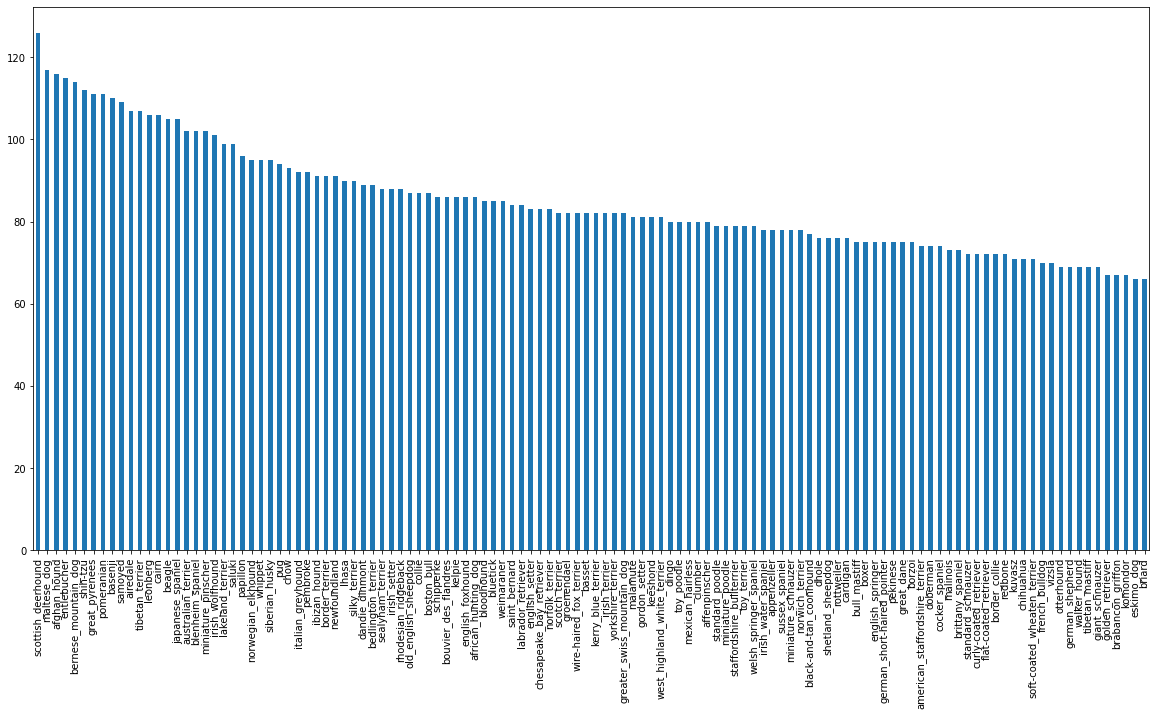

In [36]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [37]:
# What's the median number of images per class?
labels_csv["breed"].value_counts().median()

82.0

### Getting images and their labels 

In [38]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [39]:
# Create pathnames from image ID's
filenames = ["drive/My Drive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [40]:
labels_csv["breed"][9000]

'tibetan_mastiff'

In [41]:
import numpy as np
labels = labels_csv["breed"].to_numpy() 
# labels = np.array(labels) # does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [42]:
len(labels)

10222

In [43]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


In [44]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [45]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [46]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [47]:
len(labels)

10222

In [48]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [49]:
len(boolean_labels)

10222

### Creating validation set

In [50]:

# Setup X & y variables
X = filenames
y = boolean_labels

In [51]:
len(filenames)

10222

start off experimenting with ~1000 images and increase as needed.

In [52]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [53]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [54]:
# Let's have a geez at the training data
X_train[:5], y_train[:2]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa

## Preprocessing Images (turning images into Tensors)

In [55]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [56]:

image.max(), image.min()

(255, 0)

In [57]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [58]:
# turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [59]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning the data into batches

In [60]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and reutrns a typle of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [61]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [62]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [63]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [64]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Building a model


In [ ]:
IMG_SIZE

224

In [65]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [66]:
INPUT_SHAPE

[None, 224, 224, 3]

In [67]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [68]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Dog Vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback


In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [ ]:
# Fit the model to the data
# model = train_model()

## Making and evaluating predictions using a trained model 

In [ ]:
val_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [69]:
# Make predictions on the validation data
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 67s 9s/step


array([[0.00147863, 0.00138055, 0.02303961, ..., 0.00430542, 0.00820004,
        0.00344113],
       [0.01305747, 0.00372377, 0.00762924, ..., 0.0071129 , 0.01413179,
        0.00361988],
       [0.00044776, 0.00010188, 0.00088115, ..., 0.01103953, 0.00024087,
        0.00210189],
       ...,
       [0.01015268, 0.00143186, 0.00499926, ..., 0.00282438, 0.00200995,
        0.01666768],
       [0.00071134, 0.0019498 , 0.00610306, ..., 0.00376878, 0.00317363,
        0.01482225],
       [0.00229828, 0.00103061, 0.00489631, ..., 0.01487816, 0.00168165,
        0.00353102]], dtype=float32)

In [ ]:
predictions[0]

array([5.7500009e-03, 7.7991866e-02, 2.8846435e-02, 4.5107994e-03,
       1.7799010e-03, 2.0431932e-03, 2.1520996e-02, 6.7365350e-04,
       9.1538746e-03, 2.1473953e-04, 1.1882598e-02, 1.2611583e-03,
       1.9324200e-03, 2.3987887e-03, 3.5002737e-03, 4.3724303e-04,
       3.7793149e-03, 4.7696855e-02, 3.1629362e-04, 3.3950193e-03,
       9.4802752e-03, 8.7301829e-04, 5.3472503e-04, 6.0454607e-03,
       2.9360557e-03, 2.2120827e-03, 2.1880174e-02, 9.9899620e-03,
       4.1644307e-04, 3.1629740e-03, 1.6807892e-03, 2.1036819e-03,
       1.5031555e-04, 5.3394195e-03, 2.6491631e-04, 4.5309342e-03,
       9.9993413e-03, 1.7772211e-03, 1.7021416e-03, 1.4717678e-02,
       9.7824981e-05, 1.3685136e-01, 3.0675235e-03, 1.7567246e-03,
       1.8025531e-02, 2.9752254e-02, 2.1698589e-03, 2.6541457e-03,
       4.3376978e-03, 6.2031825e-03, 7.6785018e-03, 6.5037985e-03,
       1.0101238e-02, 1.0049366e-03, 1.9131225e-02, 2.2212446e-03,
       7.7902563e-03, 1.4319984e-03, 6.5630851e-03, 1.6062548e

In [ ]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[0.0016634  0.00046556 0.00448575 0.03646569 0.00157622 0.03029309
 0.0042843  0.00374811 0.0021438  0.00359552 0.00238369 0.00279912
 0.00160714 0.00629321 0.03461253 0.00391177 0.10572468 0.00043449
 0.00138451 0.00150891 0.00039459 0.02094112 0.00285048 0.00110204
 0.00164744 0.02763573 0.00046606 0.00550801 0.00062863 0.01560829
 0.0015814  0.00611058 0.00068651 0.00889491 0.00498718 0.01617289
 0.00124951 0.00520106 0.0015238  0.00164056 0.00149761 0.00142811
 0.00239724 0.00938751 0.00173076 0.00538779 0.00195033 0.00854655
 0.00379867 0.01098637 0.00129627 0.00176318 0.00704448 0.00213349
 0.0111195  0.02255308 0.01451676 0.00072077 0.00829769 0.00406835
 0.00605279 0.02440285 0.01217536 0.00059783 0.01011701 0.01085359
 0.01660049 0.00142097 0.00070252 0.02371202 0.00072293 0.01062102
 0.00522626 0.01452378 0.00198757 0.00592107 0.00132816 0.00118662
 0.01907541 0.02285516 0.00189859 0.00924457 0.00227785 0.00011599
 0.00927213 0.00733236 0.01457885 0.00463747 0.00724558 0.0049

In [ ]:
unique_breeds[113]

'walker_hound'

In [ ]:
val_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

## Saving and reloading a trained model

In [ ]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [4]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [ ]:
# Save our model trained on 1000 images
import os
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20220913-12421663072944-1000-images-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20220913-12421663072944-1000-images-mobilenetv2-Adam.h5'

In [ ]:
# Load a trained model
loaded_1000_image_model = load_model('drive/My Drive/Dog Vision/models/20220913-12421663072944-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: drive/My Drive/Dog Vision/models/20220913-12421663072944-1000-images-mobilenetv2-Adam.h5


In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 73ms/step - loss: 5.7157 - accuracy: 0.0000e+00


[5.715680122375488, 0.0]

In [ ]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 3s 182ms/step - loss: 5.7157 - accuracy: 0.0000e+00


[5.715680122375488, 0.0]

## Training a model (on the full data)

In [ ]:
len(X), len(y)

(10222, 10222)

In [ ]:
# Create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [ ]:
full_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [ ]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [ ]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 1175s 4s/step - loss: 1.3555 - accuracy: 0.6688
Epoch 2/100
320/320 [==============================] - 38s 119ms/step - loss: 0.3995 - accuracy: 0.8819
Epoch 3/100
320/320 [==============================] - 39s 121ms/step - loss: 0.2389 - accuracy: 0.9344
Epoch 4/100
320/320 [==============================] - 39s 122ms/step - loss: 0.1543 - accuracy: 0.9644
Epoch 5/100
320/320 [==============================] - 40s 124ms/step - loss: 0.1055 - accuracy: 0.9783
Epoch 6/100
320/320 [==============================] - 40s 125ms/step - loss: 0.0753 - accuracy: 0.9891
Epoch 7/100
320/320 [==============================] - 40s 126ms/step - loss: 0.0588 - accuracy: 0.9914
Epoch 8/100
320/320 [==============================] - 43s 135ms/step - loss: 0.0471 - accuracy: 0.9945
Epoch 9/100
320/320 [==============================] - 43s 136ms/step - loss: 0.0370 - accuracy: 0.9966
Epoch 10/100
320/320 [==============================] - 48s 150ms

In [ ]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20220913-13231663075406-full-image-set-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20220913-13231663075406-full-image-set-mobilenetv2-Adam.h5'

In [7]:
# Load in the full model
loaded_full_model = load_model('drive/My Drive/Dog Vision/models/20220913-13231663075406-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: drive/My Drive/Dog Vision/models/20220913-13231663075406-full-image-set-mobilenetv2-Adam.h5


## Making predictions on the test dataset

In [9]:
# Load test image filenames
import os
test_path = "drive/My Drive/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Dog Vision/test/e596c0d97b381e876d46dda2eb60074c.jpg',
 'drive/My Drive/Dog Vision/test/e2c0a9f66153b81eb27bb1bceb8c18dd.jpg',
 'drive/My Drive/Dog Vision/test/e6cc659102d490f622b3e6b4f60bfaaf.jpg',
 'drive/My Drive/Dog Vision/test/e4b76574d24800b91bdcfc886fb74f23.jpg',
 'drive/My Drive/Dog Vision/test/e1f9be3ecf0409189486c786ff4bd65a.jpg',
 'drive/My Drive/Dog Vision/test/ddfb44a70822741297344d0a9ea81f2d.jpg',
 'drive/My Drive/Dog Vision/test/e291c3955198350ab26495e9290dbe34.jpg',
 'drive/My Drive/Dog Vision/test/e3a2e1a4c44509d7aa7777d88c5cd45a.jpg',
 'drive/My Drive/Dog Vision/test/e5e51d0dfc3ccdb74de51933b2671742.jpg',
 'drive/My Drive/Dog Vision/test/e6920cc0fd2e3099506d23761d9682e1.jpg']

In [ ]:
len(test_filenames)

10357

In [14]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [15]:
test_data

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [18]:
# Load predictions (NumPy array) from csv file
import numpy as np
test_predictions = np.loadtxt("drive/My Drive/Dog Vision/preds_array.csv", delimiter=",")

In [ ]:
test_predictions[:10]

array([[1.61196489e-09, 3.44086413e-12, 2.32834394e-11, ...,
        1.06917716e-13, 1.58530451e-08, 1.52161670e-06],
       [3.17894322e-10, 3.20088262e-14, 1.85374840e-10, ...,
        7.00588814e-08, 1.88822238e-08, 2.56980937e-10],
       [4.27301083e-09, 1.84139528e-13, 1.11784948e-09, ...,
        2.71949238e-12, 2.23927123e-06, 7.41860809e-11],
       ...,
       [4.47232779e-10, 4.28004029e-07, 4.11986996e-08, ...,
        4.65437893e-07, 8.21722967e-10, 8.86002116e-09],
       [3.50528079e-11, 1.94377336e-03, 1.44941642e-10, ...,
        1.56135718e-06, 6.13228721e-08, 7.32120961e-12],
       [1.23221771e-08, 3.08354520e-09, 1.87174110e-10, ...,
        8.16165635e-10, 9.98905063e-01, 6.73740752e-09]])

In [19]:
test_predictions.shape

(10357, 120)

## Making predictions on custom images

In [21]:
# Get custom image filepaths
custom_path = "drive/My Drive/Dog Vision/dog_photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [22]:
custom_image_paths

['drive/My Drive/Dog Vision/dog_photos/continental-bulldog.jpg',
 'drive/My Drive/Dog Vision/dog_photos/husky.jpg',
 'drive/My Drive/Dog Vision/dog_photos/golden-retriever.jpg']

In [23]:
# Turn custom images into batch datasets 
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [24]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [25]:
custom_preds.shape

(3, 120)

In [70]:
# Create a function to predict the labels
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'black-and-tan_coonhound'

In [71]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['boxer', 'eskimo_dog', 'golden_retriever']

In [72]:
# Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

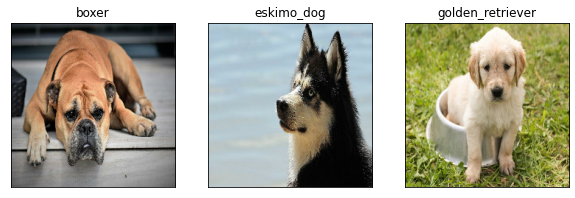

In [74]:
# Check custom image predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)